# **0. Hardware and environment**

In [ ]:
!/opt/bin/nvidia-smi

Wed May 18 19:07:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import re
import os
import numpy as np
import pandas as pd
from io import StringIO
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from torch.utils.data.dataset import Dataset
from torchvision.transforms import InterpolationMode
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Set all seeds in advance to make experiments reproducible
torch.manual_seed(2022)
torch.cuda.manual_seed(2022)
np.random.seed(2022)
random.seed(2022)
torch.backends.cudnn.deterministic = True

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **1. Prepare dataset**

## 1.1 Load dataset

In [ ]:
id = '1jV9FTvI_YQc3TJV_gE2E7DnElfn1oVUu' 

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dataset.zip')

!unzip Dataset.zip

FILENAME_TRAIN = '/content/COMP5329S1A2Dataset/train.csv'
FILENAME_TEST = '/content/COMP5329S1A2Dataset/test.csv'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: COMP5329S1A2Dataset/data/15531.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._15531.jpg  
  inflating: COMP5329S1A2Dataset/data/12538.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._12538.jpg  
  inflating: COMP5329S1A2Dataset/data/25394.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._25394.jpg  
  inflating: COMP5329S1A2Dataset/data/35187.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._35187.jpg  
  inflating: COMP5329S1A2Dataset/data/7710.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._7710.jpg  
  inflating: COMP5329S1A2Dataset/data/8423.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._8423.jpg  
  inflating: COMP5329S1A2Dataset/data/15257.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._15257.jpg  
  inflating: COMP5329S1A2Dataset/data/34299.jpg  
  inflating: __MACOSX/COMP5329S1A2Dataset/data/._34299.jpg  
  inflating: COMP5329S1A2Dataset/data/14149.jpg  
  inflating: __MACOSX/COMP5329S1A2Datas

## 1.2 Make sure all data can be read

In [ ]:
with open(FILENAME_TRAIN) as file:
    data = file.readlines()# Read each data in list
for i in [4790, 14716, 14961, 29895]: #These data rows all contain "/" at the end of the title, which would make them unreadable
    data[i] = data[i].replace("/", "")      
with open(FILENAME_TRAIN, 'w') as file: #Save modification
    file.writelines(data)

In [ ]:
with open(FILENAME_TRAIN) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train_origin = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
with open(FILENAME_TEST) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
df_train_origin

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29996,29996.jpg,1,A plate topped with a pizza being cut with a s...
29997,29997.jpg,1,A man riding a snowboard on top of snow.
29998,29998.jpg,1,This photo shows people skiing in the mountains.


In [ ]:
df_test

,ImageID,Caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...
1,30001.jpg,A beautiful young woman holding an orange fris...
2,30002.jpg,A group of people sitting on couch next to a c...
3,30003.jpg,A person on a snowboard rides on the hill.
4,30004.jpg,A man riding a skateboard with a helmet on in ...
...,...,...
9995,39995.jpg,A group of men riding surfboards riding a mass...
9996,39996.jpg,A motorcycle parked next to a car in a parking...
9997,39997.jpg,a little boy that is playing with a wii
9998,39998.jpg,group of kids play Frisbee golf in the middle ...


## 1.3 Split data into train and validation

In [ ]:
ratio=0.8
split_index = int(df_train_origin.shape[0] * ratio)
df_train = df_train_origin[ :split_index]
df_validation = df_train_origin[split_index: ]

In [ ]:
df_train

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
23995,23995.jpg,1,A group of people floating on top of waves in ...
23996,23996.jpg,1,A man wearing an orange tie and a woman wearin...
23997,23997.jpg,1 10 3 6,A large sign is lit up on a dark city street.
23998,23998.jpg,1 15,children learning to play tennis on a clay court


In [ ]:
df_validation.index = range(len(df_validation))
df_validation

,ImageID,Labels,Caption
0,24000.jpg,1,A young girl walking on a road carrying an umb...
1,24001.jpg,1,A woman with a large black purse holding an um...
2,24002.jpg,1,Two kids play over a soccer ball during a game.
3,24003.jpg,1,A man standing and cutting food at a counter.
4,24004.jpg,5,A plane is at the airport preparing to take off.
...,...,...,...
5995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
5996,29996.jpg,1,A plate topped with a pizza being cut with a s...
5997,29997.jpg,1,A man riding a snowboard on top of snow.
5998,29998.jpg,1,This photo shows people skiing in the mountains.


## 1.4 Show label distribution

There are 18 different training labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19}


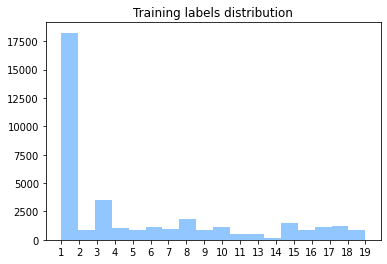

In [ ]:
df_train_label_list = []
for i in df_train['Labels']:
    df_train_label_list.extend(i.split())
df_train_label_list = sorted([int(i) for i in df_train_label_list])
df_train_label_set =set(df_train_label_list)
print(f'There are {len(df_train_label_set)} different training labels: {df_train_label_set}')

plt.style.use('seaborn-pastel')
plt.title("Training labels distribution")
plt.hist([str(i) for i in df_train_label_list], bins=len(df_train_label_set))
plt.show()

There are 18 different validation labels: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19}


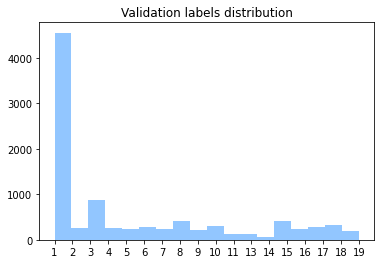

In [ ]:
import matplotlib.pyplot as plt
df_validation_label_list = []

for i in df_validation['Labels']:
    df_validation_label_list.extend(i.split())
df_validation_label_list = sorted([int(i) for i in df_validation_label_list])
df_validation_label_set =set(df_validation_label_list)
print(f'There are {len(df_validation_label_set)} different validation labels: {df_validation_label_set}')

plt.style.use('seaborn-pastel')
plt.title("Validation labels distribution")
plt.hist([str(i) for i in df_validation_label_list], bins=len(df_validation_label_set))
plt.show()



---



# **2. NLP section**

## 2.1 Preprocess captions

In [ ]:
all_caption = pd.concat([df_train_origin['Caption'], df_test['Caption']], axis=0, ignore_index=True)

In [ ]:
import nltk
#Stopword
import string
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stopwords=sw.words('english')
#Lemmatisation
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
#Tokenisation
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def preprocess_caption(caption):
    preprocessed_captions=[ ]
    for c in caption:
        clean_caption = re.sub(r'[^A-Za-z]+', ' ', c)#Remove number and punctuations
        clean_caption = clean_caption.lower() #Lowercase
        tokenized_caption = word_tokenize(clean_caption) #Tokenisation
        tokenized_caption =  [w for w in tokenized_caption if not w in stopwords]
        tokenized_caption = [lemmatizer.lemmatize(w) for w in tokenized_caption]
        preprocessed_captions.append(tokenized_caption)
    return preprocessed_captions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
all_preprocessed_captions = preprocess_caption(all_caption)

## 2.2 Construct word dict and word list

In [ ]:
word_freq_dict = nltk.FreqDist()
for caption in all_preprocessed_captions:
    for word in caption:
        word_freq_dict[word] += 1

In [ ]:
def construct_wordlist_and_worddict(all_preprocessed_captions):
    word_set = set() 
    for caption in all_preprocessed_captions:
        for word in caption:
            if word_freq_dict[word] >4:  #Low frequency words are not considered
                word_set.add(word)
    word_set.add('[PAD]')
    word_set.add('[UNKNOWN]')
    #Get word list
    word_list = list(word_set) 
    word_list.sort()
    #Get word dict
    word_dict = {}
    ind = 0
    for word in word_list:
        word_dict[word] = ind
        ind += 1
    return word_list, word_dict

In [ ]:
word_list, word_dict = construct_wordlist_and_worddict(all_preprocessed_captions)

## 2.3 Encode and pad caption

In [ ]:
max_caption_length = max(len(c) for c in all_preprocessed_captions)

In [ ]:
def encode_and_add_padding(captions, word_index):
    caption_encoded = []
    caption_length = max_caption_length
    for caption in captions:
        if not len(caption) > caption_length:
            temp_encoded = [word_index[word] if word in word_index  #If the word is in word_dict, return the corresponding value
                            else word_index['[UNKNOWN]'] #If the word is not in word_dict, then the value corresponding to [UNKNOWN] is returned
                            for word in caption] 
            if len(temp_encoded) < caption_length: #If shorter than the predetermined length, the value of [PAD] will be added
                temp_encoded += [word_index['[PAD]']] * (caption_length - len(temp_encoded))
        else:
            caption = caption[ :caption_length]
            temp_encoded = [word_index[word] if word in word_index 
                            else word_index['[UNKNOWN]'] 
                            for word in caption]
        caption_encoded.append(temp_encoded)
    return caption_encoded 

In [ ]:
all_captions_encoded = encode_and_add_padding(all_preprocessed_captions, word_dict)

In [ ]:
df_train.insert(loc=len(df_train.columns), column='Encoded_caption', value=all_captions_encoded[ :24000])
df_validation.insert(loc=len(df_validation.columns), column='Encoded_caption', value=all_captions_encoded[24000:30000])
df_test.insert(loc=len(df_test.columns), column='Encoded_caption', value=all_captions_encoded[30000: ])

In [ ]:
df_train

,ImageID,Labels,Caption,Encoded_caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.,"[2193, 1923, 1898, 922, 1335, 1903, 508, 0, 0,..."
1,1.jpg,1 19,A couple of men riding horses on top of a gree...,"[453, 1160, 1569, 932, 2010, 841, 689, 0, 0, 0..."
2,2.jpg,1,They are brave for riding in the jungle on tho...,"[1, 1569, 1, 614, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...,"[184, 1716, 374, 2024, 975, 1238, 2050, 0, 0, ..."
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.,"[2035, 413, 1855, 2029, 1705, 0, 0, 0, 0, 0, 0..."
...,...,...,...,...
23995,23995.jpg,1,A group of people floating on top of waves in ...,"[852, 1373, 721, 2010, 2157, 1267, 0, 0, 0, 0,..."
23996,23996.jpg,1,A man wearing an orange tie and a woman wearin...,"[1138, 2161, 1289, 1989, 2193, 2161, 2174, 1, ..."
23997,23997.jpg,1 10 3 6,A large sign is lit up on a dark city street.,"[1036, 1709, 1093, 506, 360, 1871, 0, 0, 0, 0,..."
23998,23998.jpg,1 15,children learning to play tennis on a clay court,"[347, 1053, 1431, 1967, 367, 455, 0, 0, 0, 0, ..."


In [ ]:
df_validation

,ImageID,Labels,Caption,Encoded_caption
0,24000.jpg,1,A young girl walking on a road carrying an umb...,"[2212, 809, 2140, 1576, 303, 2082, 0, 0, 0, 0,..."
1,24001.jpg,1,A woman with a large black purse holding an um...,"[2193, 1036, 184, 1506, 922, 2082, 0, 0, 0, 0,..."
2,24002.jpg,1,Two kids play over a soccer ball during a game.,"[2075, 1002, 1431, 1780, 109, 786, 0, 0, 0, 0,..."
3,24003.jpg,1,A man standing and cutting food at a counter.,"[1138, 1830, 499, 742, 450, 0, 0, 0, 0, 0, 0, ..."
4,24004.jpg,5,A plane is at the airport preparing to take off.,"[1424, 25, 1478, 1937, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
5995,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...,"[1398, 2059, 1173, 1576, 0, 0, 0, 0, 0, 0, 0, ..."
5996,29996.jpg,1,A plate topped with a pizza being cut with a s...,"[1428, 2011, 1418, 497, 1804, 0, 0, 0, 0, 0, 0..."
5997,29997.jpg,1,A man riding a snowboard on top of snow.,"[1138, 1569, 1773, 2010, 1772, 0, 0, 0, 0, 0, ..."
5998,29998.jpg,1,This photo shows people skiing in the mountains.,"[1388, 1698, 1373, 1739, 1208, 0, 0, 0, 0, 0, ..."


In [ ]:
df_test

,ImageID,Caption,Encoded_caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...,"[1094, 809, 1, 1018, 1, 887, 922, 216, 1018, 1..."
1,30001.jpg,A beautiful young woman holding an orange fris...,"[147, 2212, 2193, 922, 1289, 771, 0, 0, 0, 0, ..."
2,30002.jpg,A group of people sitting on couch next to a c...,"[852, 1373, 1725, 449, 1252, 397, 1932, 0, 0, ..."
3,30003.jpg,A person on a snowboard rides on the hill.,"[1381, 1773, 1567, 910, 0, 0, 0, 0, 0, 0, 0, 0..."
4,30004.jpg,A man riding a skateboard with a helmet on in ...,"[1138, 1569, 1730, 900, 424, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
9995,39995.jpg,A group of men riding surfboards riding a mass...,"[852, 1160, 1569, 1911, 1569, 1149, 2157, 0, 0..."
9996,39996.jpg,A motorcycle parked next to a car in a parking...,"[1204, 1337, 1252, 291, 1338, 1114, 0, 0, 0, 0..."
9997,39997.jpg,a little boy that is playing with a wii,"[1094, 218, 1435, 2178, 0, 0, 0, 0, 0, 0, 0, 0..."
9998,39998.jpg,group of kids play Frisbee golf in the middle ...,"[852, 1002, 1431, 771, 825, 1173, 2194, 0, 0, ..."


Woman in swim suit holding parasol on sunny day


## 2.4 Construct embedding table

In [ ]:
import gensim.downloader as api 
def counstruct_lookup_table(list_of_words):
    word_emb_model = api.load("glove-wiki-gigaword-300")
    emb_dim = word_emb_model.vector_size
    emb_table=[]
    for i, word in enumerate(list_of_words):
        if word in word_emb_model:
            emb_table.append(word_emb_model[word])
        else:
            # The pretrained glove wiki may not contain the embeddings that exists in word_list, so add zero vectors.
            emb_table.append([0]*emb_dim)
    emb_table = np.array(emb_table) 
    return emb_table

In [ ]:
#lookup_table = counstruct_lookup_table(word_list)
#np.save("lookup_table.npy", lookup_table)

In [ ]:
id = '1nDGOG4o9OkZUZGlWMt4JJ824PUd0J_T3' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('lookup_table.npy')

lookup_table = np.load("lookup_table.npy")



---



# **3. Define and transform own dataset**

## 3.1 Construct abstract class

In [ ]:
from torch._C import dtype
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import InterpolationMode
class TensorDataset(Dataset):
    """
    df=[df_train, df_validation, df_test]
    mode=[train, validation, test]
    """
    def __init__(self, df, mode):
        self.df = df
        self.mode=mode
        label_set= {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19}

        if self.mode != "test":
            self.image=[]
            self.label=[]
            self.binary_label=[]
            self.caption=[]
            #self.encoded_caption=[]
            for index, row in self.df.iterrows():
               self.image.append(row['ImageID'])
               self.label.append(row['Labels'])
               self.caption.append(row['Caption'])
               #self.encoded_caption.append(row['Encoded_caption'])
               self.encoded_caption = self.df['Encoded_caption']
            for _, item in enumerate(self.label):
                label_sub_list = item.split()
                binary_label= [1 if str(i) in label_sub_list else 0 for i in label_set]
                self.binary_label.append(np.array(binary_label, dtype=int))
        else:
            self.image=[]
            self.caption=[]
            #self.encoded_caption=[]
            for index, row in self.df.iterrows():
                self.image.append(row['ImageID'])
                self.caption.append(row['Caption'])
                #self.encoded_caption.append(row['Encoded_caption'])
                self.encoded_caption = self.df['Encoded_caption']                
        print(f'Successfully load {self.mode} set with {len(self.image)} samples')


    def __getitem__(self, idx):
        img_path = os.path.join('/content/COMP5329S1A2Dataset/data/', self.image[idx])
        img = Image.open(img_path)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        
        if self.mode == "train":
            label =  self.binary_label[idx]
            caption = self.caption[idx]
            encoded_caption = self.encoded_caption[idx]
            train_transform = transforms.Compose([
                                                    transforms.Resize((256, 256)),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ColorJitter(),
                                                    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5), 
                                                                            shear=None, interpolation=InterpolationMode.BICUBIC, 
                                                                            fill=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean, std)])
            image = train_transform(img)
            return image, np.array(encoded_caption, dtype=int), caption, label
        elif self.mode == "validation":
            label =  self.binary_label[idx]
            caption = self.caption[idx]
            encoded_caption = self.encoded_caption[idx]            
            validation_transform = transforms.Compose([transforms.Resize((256, 256)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean, std)])            
            image = validation_transform(img)
            return image, np.array(encoded_caption, dtype=int), caption, label
        else:
            caption = self.caption[idx]
            encoded_caption = self.encoded_caption[idx]            
            test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean, std)])                        
            image = test_transform(img)
            return image, np.array(encoded_caption, dtype=int), caption

    def __len__(self):
        return len(self.image)

## 3.2 Check data form

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Successfully load train set with 24000 samples


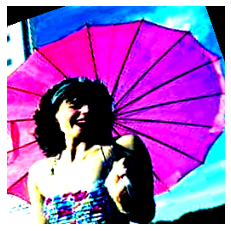

encoded_caption: [2193 1923 1898  922 1335 1903  508    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
caption: Woman in swim suit holding parasol on sunny day.
label: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Check transformed image, binarized label and caption
sample_data = TensorDataset(df_train, "train")

def transformed_image(sample):
    img = sample.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

transformed_image(sample_data[0][0]) #Tensor, size=[3, 256, 256]
print(f'encoded_caption: {sample_data[0][1]}')#ndarray, length=28
print(f'caption: {sample_data[0][2]}') #str
print(f'label: {sample_data[0][3]}') #ndarray, length=18



---



# **4. Build Bi-LSTM model**

## 4.1 Define model

In [ ]:
class Bi_LSTM(nn.Module):
    def __init__(self):
        super( ).__init__( )#python3+会自动填写super参数
        self.emb = nn.Embedding(vocab_size, emb_dim)
        #  [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor        
        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

## 4.2 Set hyperparameters

In [ ]:
vocab_size = len(word_list)
emb_table = lookup_table
emb_dim = lookup_table.shape[1]
n_classes = 18
n_hidden = 16
learning_rate = 0.005#已尝试：0.005（最优），0.001，1e-4(效果不好没保存图)
total_epoch = 10
batch_size= 32

## 4.3 Construct dataloader

In [ ]:
train_dataset = TensorDataset(df_train, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

validation_dataset = TensorDataset(df_validation, "validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

Successfully load train set with 24000 samples
Successfully load validation set with 6000 samples


## 4.4 Train model

In [ ]:
def calculate_f1(groundtrue, prediction, threshold=0.5):
    true = np.array(groundtrue, dtype=float)
    pred =  np.array(np.array(prediction) > threshold, dtype=float)
    return f1_score(y_true=true, y_pred=pred, average='samples')

In [ ]:
nlp_model = Bi_LSTM().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(nlp_model.parameters(), lr=learning_rate)
print(f'----------------------------------------------Training Begin-----------------------------------------------')
since = time.time()
train_loss=[]
val_loss=[]
train_f1=[]
val_f1=[]
for epoch in range(total_epoch):
    cum_train_loss=0.0 
    train_predicted_list=[]
    train_gt_list=[]
    for image, encoded_caption, caption, label in train_dataloader:
        #image(tensor), encoded_caption(ndarray), caption(str), label(ndarray) 
        encoded_caption_torch = encoded_caption.to(device)
        label_torch = label.float().to(device)
        #训练过程
        optimizer.zero_grad()
        nlp_model.train()
        train_outputs = nlp_model(encoded_caption_torch)#32x18 tensor(GUP)
        loss = criterion(train_outputs, label_torch)
        #累加train_loss
        cum_train_loss += loss.item()
        #收集所有结果，用于计算train_f1 score
        with torch.no_grad():
            train_outputs=train_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in train_outputs:
                train_predicted_list.append(list(temp))
            label = label.detach().cpu().numpy()
            for temp in label:
                train_gt_list.append(list(temp))
        #反向传播
        loss.backward()       
        optimizer.step()
    #每个epoch后计算一次，append进list，方便做图
    train_loss.append(cum_train_loss/len(train_dataloader))
    train_f1.append(calculate_f1(train_gt_list, train_predicted_list, threshold=0.5))

    #每个epoch后，用validation验证一次
    nlp_model.eval()
    with torch.no_grad():
        cum_val_loss=0.0  
        val_predicted_list=[]
        val_gt_list=[]   
        for image, encoded_caption, caption, label in validation_dataloader:
            val_encoded_caption_torch=encoded_caption.to(device)
            val_label_torch = label.float().to(device)
            val_outputs = nlp_model(val_encoded_caption_torch)
            loss = criterion(val_outputs, val_label_torch)
            #累加val_loss
            cum_val_loss += loss.item()
            #收集所有结果，用于计算val_f1 score
            val_outputs=val_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in val_outputs:
                val_predicted_list.append(list(temp))
            val_label = label.detach().cpu().numpy()
            for temp in val_label:
                val_gt_list.append(list(temp))
    #每次验证后append进list，方便做图
    val_loss.append(cum_val_loss/len(validation_dataloader))
    val_f1.append(calculate_f1(val_gt_list, val_predicted_list, threshold=0.5))
    
    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(train_loss[-1]):.4f}\tTrain_f1score: {(100*(train_f1[-1])):.2f}%\tVal_loss: {(val_loss[-1]):.4f}\tVal_f1score: {(100*(val_f1[-1])):.2f}%" )
print(f'----------------------------------------------Training Finish-----------------------------------------------')
time_cost = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Training Begin-----------------------------------------------
Epoch: 01 ->	Train_loss: 0.1547	Train_f1score: 65.68%	Val_loss: 0.1264	Val_f1score: 71.93%
Epoch: 02 ->	Train_loss: 0.1113	Train_f1score: 78.56%	Val_loss: 0.1106	Val_f1score: 79.67%
Epoch: 03 ->	Train_loss: 0.0999	Train_f1score: 82.78%	Val_loss: 0.1033	Val_f1score: 82.11%
Epoch: 04 ->	Train_loss: 0.0937	Train_f1score: 84.08%	Val_loss: 0.1013	Val_f1score: 82.67%
Epoch: 05 ->	Train_loss: 0.0902	Train_f1score: 84.90%	Val_loss: 0.1003	Val_f1score: 83.02%
Epoch: 06 ->	Train_loss: 0.0883	Train_f1score: 85.17%	Val_loss: 0.0988	Val_f1score: 84.05%
Epoch: 07 ->	Train_loss: 0.0861	Train_f1score: 85.52%	Val_loss: 0.0992	Val_f1score: 83.71%
Epoch: 08 ->	Train_loss: 0.0849	Train_f1score: 85.85%	Val_loss: 0.0992	Val_f1score: 84.22%
Epoch: 09 ->	Train_loss: 0.0836	Train_f1score: 85.96%	Val_loss: 0.0993	Val_f1score: 83.79%
Epoch: 10 ->	Train_loss: 0.0827	Train_f1score: 86.12%	Val_loss: 0.0989	Va

In [ ]:
# #Save model paramters
# torch.save(nlp_model.state_dict(), 'Bi_lstm_paramters.pt')

## 4.5 Show plot

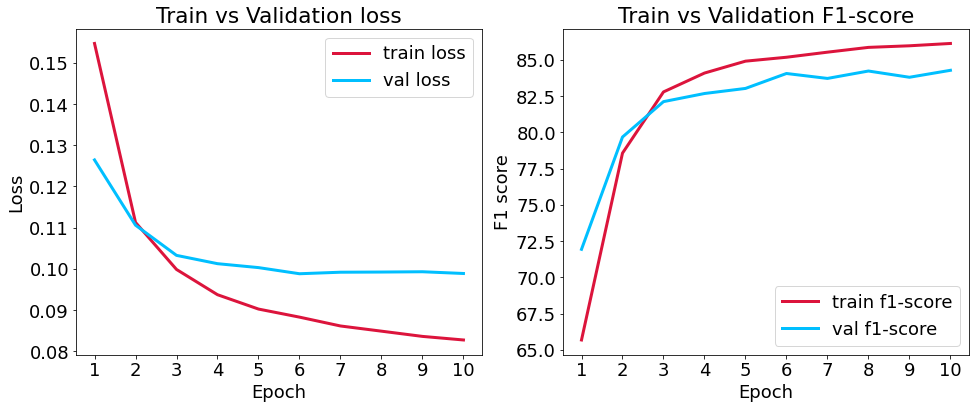

In [ ]:
Epoch=range(1,total_epoch+1)

fig = plt.figure(figsize=(16, 6))
fig.add_subplot(121)
plt.plot(Epoch, train_loss, label='train loss', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_loss, label='val loss', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")

train_f1score = np.array(train_f1)
train_f1score = np.round(train_f1score*100, 2)
val_f1score = np.array(val_f1)
val_f1score = np.round(val_f1score*100, 2)
fig.add_subplot(122)
plt.plot(Epoch, train_f1score, label='train f1-score', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_f1score, label='val f1-score', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Train vs Validation F1-score")

plt.rcParams.update({'font.size':18})
plt.show()



---



# **5. Build EffNet-b4 model**

## 5.1 Define model

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b4') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class EffNet_b4(nn.Module):
    def __init__(self):
        super( ).__init__( )
        efficientnet._fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=c7a909a9e42c6df934a7a98658645ce3d1a8475cf3e3e163be0e4d4cfd0d9f16
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


## 5.2 Set hyperparameters

In [ ]:
n_classes = 18
learning_rate = 0.0001#已尝试：0.005(效果不好)，1e-4（最优）
total_epoch = 10
batch_size= 32

## 5.3 Construct dataloader

In [ ]:
train_dataset = TensorDataset(df_train, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

validation_dataset = TensorDataset(df_validation, "validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

Successfully load train set with 24000 samples
Successfully load validation set with 6000 samples


## 5.4 Train model

In [ ]:
def calculate_f1(groundtrue, prediction, threshold=0.5):
    true = np.array(groundtrue, dtype=float)
    pred =  np.array(np.array(prediction) > threshold, dtype=float)
    return f1_score(y_true=true, y_pred=pred, average='samples')

In [ ]:
cv_model = EffNet_b4().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(cv_model.parameters(), lr=learning_rate)
print(f'----------------------------------------------Training Begin-----------------------------------------------')
since = time.time()
train_loss=[]
val_loss=[]
train_f1=[]
val_f1=[]
for epoch in range(total_epoch):
    cum_train_loss=0.0 
    train_predicted_list=[]
    train_gt_list=[]
    for image, encoded_caption, caption, label in train_dataloader:
        #image(tensor), encoded_caption(ndarray), caption(str), label(ndarray) 
        image_torch = image.to(device)
        label_torch = label.float().to(device)
        #训练过程
        optimizer.zero_grad()
        cv_model.train()
        train_outputs = cv_model(image_torch)#32x18 tensor(GUP)
        loss = criterion(train_outputs, label_torch)
        #累加train_loss
        cum_train_loss += loss.item()
        #收集所有结果，用于计算train_f1 score
        with torch.no_grad():
            train_outputs=train_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in train_outputs:
                train_predicted_list.append(list(temp))
            label = label.detach().cpu().numpy()
            for temp in label:
                train_gt_list.append(list(temp))
        #反向传播
        loss.backward()       
        optimizer.step()
    #每个epoch后计算一次，append进list，方便做图
    train_loss.append(cum_train_loss/len(train_dataloader))
    train_f1.append(calculate_f1(train_gt_list, train_predicted_list, threshold=0.5))

    #每个epoch后，用validation验证一次
    cv_model.eval()
    with torch.no_grad():
        cum_val_loss=0.0  
        val_predicted_list=[]
        val_gt_list=[]   
        for image, encoded_caption, caption, label in validation_dataloader:
            val_image_torch=image.to(device)
            val_label_torch = label.float().to(device)
            val_outputs = cv_model(val_image_torch)
            loss = criterion(val_outputs, val_label_torch)
            #累加val_loss
            cum_val_loss += loss.item()
            #收集所有结果，用于计算val_f1 score
            val_outputs=val_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in val_outputs:
                val_predicted_list.append(list(temp))
            val_label = label.detach().cpu().numpy()
            for temp in val_label:
                val_gt_list.append(list(temp))
    #每次验证后append进list，方便做图
    val_loss.append(cum_val_loss/len(validation_dataloader))
    val_f1.append(calculate_f1(val_gt_list, val_predicted_list, threshold=0.5))
    
    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(train_loss[-1]):.4f}\tTrain_f1score: {(100*(train_f1[-1])):.2f}%\tVal_loss: {(val_loss[-1]):.4f}\tVal_f1score: {(100*(val_f1[-1])):.2f}%" )
print(f'----------------------------------------------Training Finish-----------------------------------------------')
time_cost = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Training Begin-----------------------------------------------
Epoch: 01 ->	Train_loss: 0.2019	Train_f1score: 64.05%	Val_loss: 0.1188	Val_f1score: 76.56%
Epoch: 02 ->	Train_loss: 0.1116	Train_f1score: 76.98%	Val_loss: 0.0922	Val_f1score: 83.12%
Epoch: 03 ->	Train_loss: 0.0961	Train_f1score: 81.10%	Val_loss: 0.0892	Val_f1score: 83.80%
Epoch: 04 ->	Train_loss: 0.0877	Train_f1score: 83.17%	Val_loss: 0.0855	Val_f1score: 84.53%
Epoch: 05 ->	Train_loss: 0.0804	Train_f1score: 84.97%	Val_loss: 0.0834	Val_f1score: 85.35%
Epoch: 06 ->	Train_loss: 0.0747	Train_f1score: 86.21%	Val_loss: 0.0843	Val_f1score: 85.31%
Epoch: 07 ->	Train_loss: 0.0702	Train_f1score: 87.20%	Val_loss: 0.0837	Val_f1score: 85.49%
Epoch: 08 ->	Train_loss: 0.0643	Train_f1score: 88.33%	Val_loss: 0.0871	Val_f1score: 85.14%
Epoch: 09 ->	Train_loss: 0.0601	Train_f1score: 89.14%	Val_loss: 0.0874	Val_f1score: 85.27%
Epoch: 10 ->	Train_loss: 0.0559	Train_f1score: 90.12%	Val_loss: 0.0900	Va

In [ ]:
#Save model paramters
torch.save(cv_model.state_dict(), 'EffNet_b4_paramters.pt')

## 5.5 Show plot

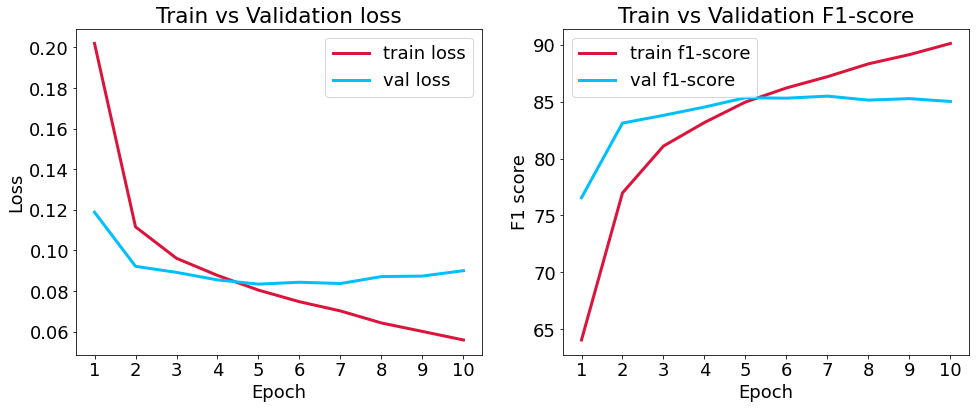

In [ ]:
Epoch=range(1,total_epoch+1)

fig = plt.figure(figsize=(16, 6))
fig.add_subplot(121)
plt.plot(Epoch, train_loss, label='train loss', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_loss, label='val loss', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")

train_f1score = np.array(train_f1)
train_f1score = np.round(train_f1score*100, 2)
val_f1score = np.array(val_f1)
val_f1score = np.round(val_f1score*100, 2)
fig.add_subplot(122)
plt.plot(Epoch, train_f1score, label='train f1-score', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_f1score, label='val f1-score', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Train vs Validation F1-score")

plt.rcParams.update({'font.size':18})
plt.show()



---



# **6. Build final classifier**

## 6.1 Define model

In [ ]:
class Bi_LSTM(nn.Module):
    def __init__(self):
        super( ).__init__( )#省略super参数
        self.emb = nn.Embedding(vocab_size, emb_dim)
        #  [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor        
        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b4') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class EffNet_b4(nn.Module):
    def __init__(self):
        super( ).__init__( )
        efficientnet._fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

Loaded pretrained weights for efficientnet-b4


## 6.2 Set hyperparameters

In [ ]:
vocab_size = len(word_list)
emb_table = lookup_table
emb_dim = lookup_table.shape[1]
n_classes = 18
n_hidden = 16
learning_rate = 1e-4
total_epoch = 10
batch_size= 32

## 6.3 Download pretrained weights

In [ ]:
#Load Bi-lstm weights parameters trained in the previous step
id = '198okfTslAs97Kcf0U0uCtOYex20Pc8r-' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Bi_lstm_paramters.pt')

nlp_model = Bi_LSTM().to(device)
Bi_lstm_weights = torch.load('Bi_lstm_paramters.pt')
nlp_model.load_state_dict(Bi_lstm_weights) #Load the weight parameters trained in the previous step
for p in nlp_model.parameters(): #Parameters can be updated
    p.requires_grad=True
# #check 
# nlp_model.eval()

In [ ]:
#Load EffNet-b4 weights parameters trained in the previous step
id = '1pin4l5e0hGr3_z1BxtAzBJic7aSqdkgO'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EffNet_b4_paramters.pt')

cv_model = EffNet_b4().to(device)
EffNet_b4_weights = torch.load('EffNet_b4_paramters.pt')
cv_model.load_state_dict(EffNet_b4_weights) #Load the weight parameters trained in the previous step
for p in cv_model.parameters(): #Parameters can be updated
    p.requires_grad=True
# #check 
# cv_model.eval()

## 6.4 Define final classifier

In [ ]:
final_classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=2392),
    nn.ReLU(),
    nn.Linear(in_features=2392, out_features=n_classes)
    #,nn.Sigmoid() 尝试使用BCEWithLogitsLoss
)
final_classifier = final_classifier.to(device)

## 6.5 Construct dataloader

In [ ]:
train_dataset = TensorDataset(df_train, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

validation_dataset = TensorDataset(df_validation, "validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

Successfully load train set with 24000 samples
Successfully load validation set with 6000 samples


## 6.6 Train model

In [ ]:
def calculate_f1(groundtrue, prediction, threshold=0.5):
    true = np.array(groundtrue, dtype=float)
    pred =  np.array(np.array(prediction) > threshold, dtype=float)
    return f1_score(y_true=true, y_pred=pred, average='samples')

In [ ]:
#已实例化nlp_model，cv_model，final_classifier
criterion = nn.BCEWithLogitsLoss()#尝试使用BCEWithLogitsLoss
optimizer = optim.AdamW(final_classifier.parameters(), lr=learning_rate) #反向传播仅更新classifier的权重参数
print(f'----------------------------------------------Training Begin-----------------------------------------------')
since = time.time()
train_loss=[]
val_loss=[]
train_f1=[]
val_f1=[]
for epoch in range(total_epoch):
    cum_train_loss=0.0 
    train_predicted_list=[]
    train_gt_list=[]
    for image, encoded_caption, caption, label in train_dataloader:
        #image(tensor), encoded_caption(ndarray), caption(str), label(ndarray) 
        encoded_caption_torch = encoded_caption.to(device)  #nlp_model的输入
        image_torch = image.to(device) #cv_model的输入
        label_torch = label.float().to(device)         
        #训练过程
        optimizer.zero_grad()

        nlp_model.train()
        cv_model.train()
        nlp_train_outputs = nlp_model(encoded_caption_torch)#32x18 tensor(GUP) logits
        cv_train_outputs = cv_model(image_torch)#32x18 tensor(GUP) logits
        #将两个输出值拼接一起
        concat_train_outputs = torch.cat((nlp_train_outputs, cv_train_outputs),1) #32x36 tensor(GUP) logits
        #训练final_classifier
        final_train_outputs = final_classifier(concat_train_outputs)
        loss = criterion(final_train_outputs, label_torch)
        #累加train_loss
        cum_train_loss += loss.item()
        #收集所有结果，用于计算train_f1 score
        with torch.no_grad():
            final_train_outputs=final_train_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in final_train_outputs:
                train_predicted_list.append(list(temp))
            label = label.detach().cpu().numpy()
            for temp in label:
                train_gt_list.append(list(temp))
        #反向传播
        loss.backward()       
        optimizer.step()
    #每个epoch后计算一次，append进list，方便做图
    train_loss.append(cum_train_loss/len(train_dataloader))
    train_f1.append(calculate_f1(train_gt_list, train_predicted_list, threshold=0.5))

    #每个epoch后，用validation验证一次
    nlp_model.eval()
    cv_model.eval()
    with torch.no_grad():
        cum_val_loss=0.0  
        val_predicted_list=[]
        val_gt_list=[]   
        for image, encoded_caption, caption, label in validation_dataloader:
            val_encoded_caption_torch=encoded_caption.to(device)
            val_image_torch = image.to(device) #cv_model的输入
            val_label_torch = label.float().to(device)
            
            nlp_val_outputs = nlp_model(val_encoded_caption_torch)
            cv_val_outputs = cv_model(val_image_torch)
            concat_val_outputs = torch.cat((nlp_val_outputs, cv_val_outputs),1)
            final_val_outputs = final_classifier(concat_val_outputs)
            loss = criterion(final_val_outputs, val_label_torch)
            #累加val_loss
            cum_val_loss += loss.item()
            #收集所有结果，用于计算final_val_f1 score
            final_val_outputs=final_val_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in final_val_outputs:
                val_predicted_list.append(list(temp))
            val_label = label.detach().cpu().numpy()
            for temp in val_label:
                val_gt_list.append(list(temp))
    #每次验证后append进list，方便做图
    val_loss.append(cum_val_loss/len(validation_dataloader))
    val_f1.append(calculate_f1(val_gt_list, val_predicted_list, threshold=0.5))
    
    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(train_loss[-1]):.4f}\tTrain_f1score: {(100*(train_f1[-1])):.2f}%\tVal_loss: {(val_loss[-1]):.4f}\tVal_f1score: {(100*(val_f1[-1])):.2f}%" )
print(f'----------------------------------------------Training Finish-----------------------------------------------')
time_cost = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Training Begin-----------------------------------------------
Epoch: 01 ->	Train_loss: 0.1688	Train_f1score: 66.99%	Val_loss: 0.0915	Val_f1score: 81.74%
Epoch: 02 ->	Train_loss: 0.0594	Train_f1score: 89.53%	Val_loss: 0.0789	Val_f1score: 86.72%
Epoch: 03 ->	Train_loss: 0.0503	Train_f1score: 92.00%	Val_loss: 0.0781	Val_f1score: 87.55%
Epoch: 04 ->	Train_loss: 0.0483	Train_f1score: 92.49%	Val_loss: 0.0783	Val_f1score: 87.77%
Epoch: 05 ->	Train_loss: 0.0470	Train_f1score: 92.82%	Val_loss: 0.0784	Val_f1score: 87.95%
Epoch: 06 ->	Train_loss: 0.0461	Train_f1score: 92.88%	Val_loss: 0.0785	Val_f1score: 88.04%
Epoch: 07 ->	Train_loss: 0.0456	Train_f1score: 93.03%	Val_loss: 0.0787	Val_f1score: 88.05%
Epoch: 08 ->	Train_loss: 0.0454	Train_f1score: 93.06%	Val_loss: 0.0786	Val_f1score: 88.16%
Epoch: 09 ->	Train_loss: 0.0449	Train_f1score: 93.09%	Val_loss: 0.0787	Val_f1score: 88.23%
Epoch: 10 ->	Train_loss: 0.0445	Train_f1score: 93.13%	Val_loss: 0.0785	Va

In [ ]:
#Save model paramters
torch.save(final_classifier.state_dict(), 'final_classifier_paramters.pt')

## 6.7 Show plot

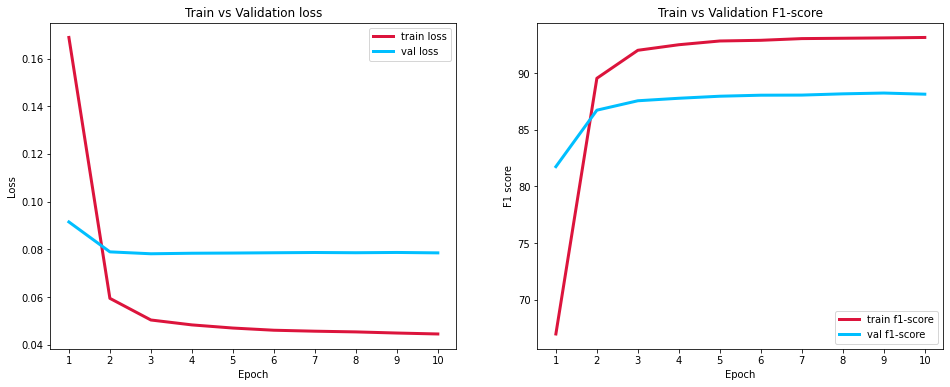

In [ ]:
Epoch=range(1,total_epoch+1)

fig = plt.figure(figsize=(16, 6))
fig.add_subplot(121)
plt.plot(Epoch, train_loss, label='train loss', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_loss, label='val loss', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")

train_f1score = np.array(train_f1)
train_f1score = np.round(train_f1score*100, 2)
val_f1score = np.array(val_f1)
val_f1score = np.round(val_f1score*100, 2)
fig.add_subplot(122)
plt.plot(Epoch, train_f1score, label='train f1-score', linewidth =3.0, color='crimson')
plt.plot(Epoch, val_f1score, label='val f1-score', linewidth =3.0, color='deepskyblue')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Train vs Validation F1-score")

plt.rcParams.update({'font.size':18})
plt.show()

# **7. Evaluation**

## 7.1 Set hyperparameters

In [ ]:
vocab_size = len(word_list)
emb_table = lookup_table
emb_dim = lookup_table.shape[1]
n_classes = 18
n_hidden = 16
learning_rate = 1e-4
total_epoch = 2
batch_size= 16

## 7.2 Define model

In [ ]:
class NLP_Model(nn.Module):
    def __init__(self):
        super( ).__init__( )#省略super参数
        self.emb = nn.Embedding(vocab_size, emb_dim)
        #  [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor        
        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b4') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class CV_Model(nn.Module):
    def __init__(self):
        super( ).__init__( )
        efficientnet._fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

Final_Classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=2392),
    nn.ReLU(),
    nn.Linear(in_features=2392, out_features=n_classes),
    nn.Sigmoid()
)

Loaded pretrained weights for efficientnet-b4


## 7.3 Download pretrained weights

In [ ]:
#Load Bi-lstm weights parameters trained in the previous step (section 4)
id = '198okfTslAs97Kcf0U0uCtOYex20Pc8r-' #84.27
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Bi_lstm_paramters.pt')

nlp_model = NLP_Model().to(device)
NLP_Model_weights = torch.load('Bi_lstm_paramters.pt')
nlp_model.load_state_dict(NLP_Model_weights) #Load the weight parameters trained in the previous step
for p in nlp_model.parameters(): #Parameters can not be updated
    p.requires_grad=False
#check 
nlp_model.eval()

In [ ]:
#Load EffNet-b4 weights parameters trained in the previous step (section 5)
id = '1pin4l5e0hGr3_z1BxtAzBJic7aSqdkgO'#85.02
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EffNet_b4_paramters.pt')

cv_model = CV_Model().to(device)
CV_Model_weights = torch.load('EffNet_b4_paramters.pt')
cv_model.load_state_dict(CV_Model_weights) #Load the weight parameters trained in the previous step
for p in cv_model.parameters(): #Parameters can not be updated
    p.requires_grad=False
#check 
cv_model.eval()

In [ ]:
#Load finalclassifier weights parameters trained in the previous step (section 6)
id = '1t8z8RDTFwouKOmcr_Y-BusHRkdUV5hu8' #88.24
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('final_classifier_paramters.pt')

final_classifier = Final_Classifier.to(device)
Final_Classifier_weights = torch.load('final_classifier_paramters.pt')
final_classifier.load_state_dict(Final_Classifier_weights) #Load the weight parameters trained in the previous step
# for p in final_classifier.parameters(): #Parameters can not be updated
#     p.requires_grad=False

<All keys matched successfully>

## 7.4 Construct dataloader

In [ ]:
train_dataset = TensorDataset(df_train, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)
validation_dataset = TensorDataset(df_validation, "validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False)
test_dataset = TensorDataset(df_test, "test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False, drop_last=False)

Successfully load train set with 24000 samples
Successfully load validation set with 6000 samples
Successfully load test set with 10000 samples


## 7.5 Evaluate the model

In [ ]:
def calculate_f1(groundtrue, prediction, threshold=0.5):
    true = np.array(groundtrue, dtype=float)
    pred =  np.array(np.array(prediction) > threshold, dtype=float)
    return f1_score(y_true=true, y_pred=pred, average='samples')

In [ ]:
nlp_model.eval()
cv_model.eval()
with torch.no_grad():
    cum_val_loss=0.0
    val_predicted_list=[]
    val_gt_list=[]
    val_loss=[]
    val_f1=[]
print(f'----------------------------------------------Evaluation Begin-----------------------------------------------')
since = time.time()
for image, encoded_caption, caption, label in validation_dataloader:
    val_encoded_caption_torch=encoded_caption.to(device)
    val_image_torch = image.to(device)
    val_label_torch = label.float().to(device)
    
    nlp_val_outputs = nlp_model(val_encoded_caption_torch)
    cv_val_outputs = cv_model(val_image_torch)
    concat_val_outputs = torch.cat((nlp_val_outputs, cv_val_outputs),1)
    final_val_outputs = final_classifier(concat_val_outputs)
    loss = nn.BCELoss()(final_val_outputs, val_label_torch)
    #累加val_loss
    cum_val_loss += loss.item()
    #收集所有结果，用于计算final_val_f1 score    
    final_val_outputs=final_val_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
    for temp in final_val_outputs:
        val_predicted_list.append(list(temp))
    val_label = label.detach().cpu().numpy()
    for temp in val_label:
        val_gt_list.append(list(temp))

val_loss.append(cum_val_loss/len(validation_dataloader))
val_f1.append(calculate_f1(val_gt_list, val_predicted_list, threshold=0.5))    
print(f"Val_loss: {(val_loss[-1]):.4f}\tVal_f1score: {(100*(val_f1[-1])):.2f}%" )
print(f'----------------------------------------------Evaluation Finish-----------------------------------------------')
time_cost = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Evaluation Begin-----------------------------------------------
Val_loss: 0.0756	Val_f1score: 88.32%
----------------------------------------------Evaluation Finish-----------------------------------------------
Training complete in 0m 40s


## 7.6 Predict the result 

In [ ]:
nlp_model.eval()
cv_model.eval()
with torch.no_grad():
    test_prediction=[]
print(f'----------------------------------------------Prediction Begin-----------------------------------------------')
since = time.time()
for image, encoded_caption, caption in test_dataloader:
    test_encoded_caption_torch=encoded_caption.to(device)
    test_image_torch = image.to(device)
    
    nlp_test_outputs = nlp_model(test_encoded_caption_torch)
    cv_test_outputs = cv_model(test_image_torch)
    concat_test_outputs = torch.cat((nlp_test_outputs, cv_test_outputs), 1)
    final_test_outputs = final_classifier(concat_test_outputs)
    for temp in final_test_outputs.detach().cpu().numpy():
        test_prediction.append(list(temp))
test_prediction =  np.array(np.array(test_prediction) > 0.55, dtype=int)

time_cost = time.time() - since
print(f'----------------------------------------------Prediction Finish-----------------------------------------------')
print(f'The result of {len(test_prediction)} pieces of data has been predicted')
print('Prediction complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Prediction Begin-----------------------------------------------
----------------------------------------------Prediction Finish-----------------------------------------------
The result of 10000 pieces of data has been predicted
Prediction complete in 1m 13s


## 7.7 Generate CSV

In [ ]:
prediction_list=[]
for row in test_prediction:
    prediction_sublist=[]
    for index, value in enumerate(row):
        if index<11:
            if value ==1:
                prediction_sublist.append(index+1)
        else:
            if value ==1:
                prediction_sublist.append(index+2)
    prediction_list.append(prediction_sublist)

In [ ]:
df_prediction= pd.DataFrame(columns=["ImageID", "Labels"])
for index, value in enumerate(prediction_list):
    df_temp = pd.DataFrame({"ImageID":"{}.jpg".format(30000+index), "Labels":" ".join([str(i) for i in value])}, index=[0])
    df_prediction = df_prediction.append(df_temp, ignore_index = True)    

In [ ]:
df_prediction

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1 15
3,30003.jpg,1
4,30004.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,3 4 8
9997,39997.jpg,1
9998,39998.jpg,1


In [ ]:
# Save file
df_prediction.to_csv('prediction.csv', index =False)

# **8. Appendix**

Just for combining Bi-LSTM with EfficientNet-b3 (Not the best model)

## 8.1 Define model

In [ ]:
class Bi_LSTM(nn.Module):
    def __init__(self):
        super( ).__init__( )#省略super参数
        self.emb = nn.Embedding(vocab_size, emb_dim)
        #  [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True) #Bi_LSTM
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x) # Get the embeded tensor        
        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
efficientnet = EfficientNet.from_pretrained('efficientnet-b3') 
#Reference: https://stackoverflow.com/questions/68047331/how-to-add-the-last-classification-layer-in-efficienet-pre-trained-model-in-pyto
class EffNet_b3(nn.Module):
    def __init__(self):
        super( ).__init__( )
        efficientnet._fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(in_features = efficientnet._fc.in_features, out_features = n_classes))
        self.base_model = efficientnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

## 8.2 Set hyperparameters

In [ ]:
vocab_size = len(word_list)
emb_table = lookup_table
emb_dim = lookup_table.shape[1]
n_classes = 18
n_hidden = 16
learning_rate = 1e-4
total_epoch = 10
batch_size= 32

## 8.3 Download pretrained weights

In [ ]:
#Load Bi-lstm weights parameters trained in the previous step
id = '198okfTslAs97Kcf0U0uCtOYex20Pc8r-' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Bi_lstm_paramters.pt')

nlp_model = Bi_LSTM().to(device)
Bi_lstm_weights = torch.load('Bi_lstm_paramters.pt')
nlp_model.load_state_dict(Bi_lstm_weights) #Load the weight parameters trained in the previous step
for p in nlp_model.parameters(): #Parameters can be updated
    p.requires_grad=True
# #check 
# nlp_model.eval()

In [ ]:
#Load EffNet-b3 weights parameters trained in the previous step
id = '1WmCSd_0d5S1_J7oV7e6fYWaF7Rmklfrb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('EffNet_b3_paramters.pt')

cv_model = EffNet_b4().to(device)
EffNet_b4_weights = torch.load('EffNet_b3_paramters.pt')
cv_model.load_state_dict(EffNet_b4_weights) #Load the weight parameters trained in the previous step
for p in cv_model.parameters(): #Parameters can be updated
    p.requires_grad=True
# #check 
# cv_model.eval()

## 8.4 Define final classifier

In [ ]:
final_classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=2392),
    nn.ReLU(),
    nn.Linear(in_features=2392, out_features=n_classes)
    #,nn.Sigmoid() 尝试使用BCEWithLogitsLoss
)
final_classifier = final_classifier.to(device)

## 8.5 Construct dataloader

In [ ]:
train_dataset = TensorDataset(df_train, "train")
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

validation_dataset = TensorDataset(df_validation, "validation")
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

Successfully load train set with 24000 samples
Successfully load validation set with 6000 samples


## 8.6 Train model

In [ ]:
def calculate_f1(groundtrue, prediction, threshold=0.5):
    true = np.array(groundtrue, dtype=float)
    pred =  np.array(np.array(prediction) > threshold, dtype=float)
    return f1_score(y_true=true, y_pred=pred, average='samples')

In [3]:
#已实例化nlp_model，cv_model，final_classifier
criterion = nn.BCEWithLogitsLoss()#尝试使用BCEWithLogitsLoss
optimizer = optim.AdamW(final_classifier.parameters(), lr=learning_rate) #反向传播仅更新classifier的权重参数
print(f'----------------------------------------------Training Begin-----------------------------------------------')
since = time.time()
train_loss=[]
val_loss=[]
train_f1=[]
val_f1=[]
for epoch in range(total_epoch):
    cum_train_loss=0.0 
    train_predicted_list=[]
    train_gt_list=[]
    for image, encoded_caption, caption, label in train_dataloader:
        #image(tensor), encoded_caption(ndarray), caption(str), label(ndarray) 
        encoded_caption_torch = encoded_caption.to(device)  #nlp_model的输入
        image_torch = image.to(device) #cv_model的输入
        label_torch = label.float().to(device)         
        #训练过程
        optimizer.zero_grad()

        nlp_model.train()
        cv_model.train()
        nlp_train_outputs = nlp_model(encoded_caption_torch)#32x18 tensor(GUP) logits
        cv_train_outputs = cv_model(image_torch)#32x18 tensor(GUP) logits
        #将两个输出值拼接一起
        concat_train_outputs = torch.cat((nlp_train_outputs, cv_train_outputs),1) #32x36 tensor(GUP) logits
        #训练final_classifier
        final_train_outputs = final_classifier(concat_train_outputs)
        loss = criterion(final_train_outputs, label_torch)
        #累加train_loss
        cum_train_loss += loss.item()
        #收集所有结果，用于计算train_f1 score
        with torch.no_grad():
            final_train_outputs=final_train_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in final_train_outputs:
                train_predicted_list.append(list(temp))
            label = label.detach().cpu().numpy()
            for temp in label:
                train_gt_list.append(list(temp))
        #反向传播
        loss.backward()       
        optimizer.step()
    #每个epoch后计算一次，append进list，方便做图
    train_loss.append(cum_train_loss/len(train_dataloader))
    train_f1.append(calculate_f1(train_gt_list, train_predicted_list, threshold=0.5))

    #每个epoch后，用validation验证一次
    nlp_model.eval()
    cv_model.eval()
    with torch.no_grad():
        cum_val_loss=0.0  
        val_predicted_list=[]
        val_gt_list=[]   
        for image, encoded_caption, caption, label in validation_dataloader:
            val_encoded_caption_torch=encoded_caption.to(device)
            val_image_torch = image.to(device) #cv_model的输入
            val_label_torch = label.float().to(device)
            
            nlp_val_outputs = nlp_model(val_encoded_caption_torch)
            cv_val_outputs = cv_model(val_image_torch)
            concat_val_outputs = torch.cat((nlp_val_outputs, cv_val_outputs),1)
            final_val_outputs = final_classifier(concat_val_outputs)
            loss = criterion(final_val_outputs, val_label_torch)
            #累加val_loss
            cum_val_loss += loss.item()
            #收集所有结果，用于计算final_val_f1 score
            final_val_outputs=final_val_outputs.detach().cpu().numpy() #train_outputs.cpu().numpy()返回32x18 ndarray
            for temp in final_val_outputs:
                val_predicted_list.append(list(temp))
            val_label = label.detach().cpu().numpy()
            for temp in val_label:
                val_gt_list.append(list(temp))
    #每次验证后append进list，方便做图
    val_loss.append(cum_val_loss/len(validation_dataloader))
    val_f1.append(calculate_f1(val_gt_list, val_predicted_list, threshold=0.5))
    
    print(f"Epoch: {(epoch+1):02d} ->\tTrain_loss: {(train_loss[-1]):.4f}\tTrain_f1score: {(100*(train_f1[-1])):.2f}%\tVal_loss: {(val_loss[-1]):.4f}\tVal_f1score: {(100*(val_f1[-1])):.2f}%" )
print(f'----------------------------------------------Training Finish-----------------------------------------------')
time_cost = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_cost // 60, time_cost % 60))

----------------------------------------------Training Begin-----------------------------------------------
Epoch: 01 ->	Train_loss: 0.1728	Train_f1score: 66.42%	Val_loss: 0.0985	Val_f1score: 80.54%
Epoch: 02 ->	Train_loss: 0.0604	Train_f1score: 89.73%	Val_loss: 0.0897	Val_f1score: 84.82%
Epoch: 03 ->	Train_loss: 0.0573	Train_f1score: 91.82%	Val_loss: 0.0811	Val_f1score: 86.42%
Epoch: 04 ->	Train_loss: 0.0542	Train_f1score: 91.93%	Val_loss: 0.0811	Val_f1score: 86.53%
Epoch: 05 ->	Train_loss: 0.0531	Train_f1score: 92.04%	Val_loss: 0.0803	Val_f1score: 86.78%
Epoch: 06 ->	Train_loss: 0.0481	Train_f1score: 92.18%	Val_loss: 0.0801	Val_f1score: 86.74%
Epoch: 07 ->	Train_loss: 0.0476	Train_f1score: 93.23%	Val_loss: 0.0794	Val_f1score: 86.88%
Epoch: 08 ->	Train_loss: 0.0474	Train_f1score: 93.27%	Val_loss: 0.0795	Val_f1score: 86.93%
Epoch: 09 ->	Train_loss: 0.0479	Train_f1score: 93.31%	Val_loss: 0.0796	Val_f1score: 86.98%
Epoch: 10 ->	Train_loss: 0.0475	Train_f1score: 93.33%	Val_loss: 0.0795	Va

In [ ]:
# #Save model paramters
# torch.save(final_classifier.state_dict(), 'app_final_classifier_paramters.pt')